In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, '../..')

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import argparse
from torchvision.models import resnet50
import torchvision.transforms as T
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as T
from torchvision.models.resnet import *
from torchvision.datasets import ImageFolder
import numpy as np
from datasets import StanfordDogs
from utils.dataset_utils import get_subsampled_dataset, get_train_val_split, permute_pixels, get_inverse_normalization, \
    get_normalization
from utils.validation import evaluate
import seaborn as sns

In [2]:
torch.set_num_threads(4)

In [3]:
model = resnet50(num_classes=120)
model_ls = resnet50(num_classes=120)
model_regularized = resnet50(num_classes=120)
model.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_target.pt'))
model_ls.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_LS_0.1_target.pt'))
model_regularized.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_L2_0.001_target.pt'))

model = model.cuda()
model_ls = model_ls.cuda()
model_regularized = model_regularized.cuda()
model.eval()
model_ls.eval()
model_regularized.eval();

In [4]:
transformation = T.Compose(
        [
            T.Resize(224),
            T.CenterCrop((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
)


dataset_no_augmentation = StanfordDogs('../data', transform=transformation, all_data=True)
dataset_train_no_augmentation, dataset_test = get_train_val_split(dataset_no_augmentation, 0.8, seed=42)
dataset_train_no_augmentation_target, dataset_train_no_augmentation_shadow = get_train_val_split(dataset_train_no_augmentation, 0.5, seed=42)
member_target = get_subsampled_dataset(dataset_train_no_augmentation_target, dataset_size=1000, seed=42)
non_member_target = get_subsampled_dataset(dataset_test, dataset_size=1000, seed=42)

afhq_dataset = ImageFolder('../data/afhq/train', transformation)
afhq_cats = Subset(afhq_dataset, np.where(np.array(afhq_dataset.targets) == 0)[0])
afhq_cats = get_subsampled_dataset(afhq_cats, dataset_size=1000, seed=42)

In [5]:
print(evaluate(model, member_target, num_workers=0))
print(evaluate(model, non_member_target, num_workers=0))
print(evaluate(model_ls, member_target, num_workers=0))
print(evaluate(model_ls, non_member_target, num_workers=0))
print(evaluate(model_regularized, member_target, num_workers=0))
print(evaluate(model_regularized, non_member_target, num_workers=0))

tensor(0.9860, device='cuda:0')
tensor(0.6080, device='cuda:0')
tensor(0.9960, device='cuda:0')
tensor(0.6370, device='cuda:0')
tensor(0.7590, device='cuda:0')
tensor(0.4930, device='cuda:0')


In [6]:
model.fc = nn.Flatten()
model_ls.fc = nn.Flatten()
model_regularized.fc = nn.Flatten()

In [35]:
def create_tsne2(model, member, non_member, ood, filename, add_legend=False):
    member_loader = torch.utils.data.DataLoader(member_target, batch_size=128, shuffle=False)
    non_member_loader = torch.utils.data.DataLoader(non_member_target, batch_size=128, shuffle=False)
    ood_loader = torch.utils.data.DataLoader(afhq_cats, batch_size=128, shuffle=False)
    model.eval()
    model.cuda()
    
    out_target = []
    out_output = []
    out_label = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(ood_loader):
            inputs, targets = inputs.cuda(), torch.full_like(targets, 2).cuda()
            outputs = model(inputs)
            output_np = outputs.data.cpu().numpy()
            target_np = targets.data.cpu().numpy()
            out_output.append(output_np)
            out_target.append(target_np[:,np.newaxis])
            out_label += ['Non-Member (Cats)' for i in range(len(inputs))]
        
        for batch_idx, (inputs, targets) in enumerate(non_member_loader):
            inputs, targets = inputs.cuda(), torch.ones_like(targets).cuda()
            outputs = model(inputs)
            output_np = outputs.data.cpu().numpy()
            target_np = targets.data.cpu().numpy()
            out_output.append(output_np)
            out_target.append(target_np[:,np.newaxis])
            out_label += ['Non-Member (Dogs)' for i in range(len(inputs))]
            
        for batch_idx, (inputs, targets) in enumerate(member_loader):
            inputs, targets = inputs.cuda(), torch.zeros_like(targets).cuda()
            outputs = model(inputs)
            output_np = outputs.data.cpu().numpy()
            target_np = targets.data.cpu().numpy()
            out_output.append(output_np)
            out_target.append(target_np[:,np.newaxis])
            out_label += ['Member (Dogs)' for i in range(len(inputs))]


    output_array = np.concatenate(out_output, axis=0)
    target_array = np.concatenate(out_target, axis=0)
    
    tsne = TSNE(n_components=2, init='pca', random_state=13, perplexity=30, learning_rate=100)
    output_array = tsne.fit_transform(output_array)
    tx = output_array[:, 0]
    ty = output_array[:, 1]
    
    color_dict = dict({'Non-Member (Cats)' :'red',
                      'Member (Dogs)':'darkorange',
                      'Non-Member (Dogs)': 'blue'})
    plt.rcParams['figure.figsize'] = 10,10
    if add_legend:
        scatter = sns.scatterplot(tx, ty, hue=out_label, legend='full', s=100, palette=color_dict, hue_order = ['Member (Dogs)', 'Non-Member (Dogs)', 'Non-Member (Cats)'])
    else:
        scatter = sns.scatterplot(tx, ty, hue=out_label, legend=None, s=100, palette=color_dict, hue_order = ['Member (Dogs)', 'Non-Member (Dogs)', 'Non-Member (Cats)'])
    plt.xticks([])
    plt.yticks([])  
    if add_legend: 
        lgnd = plt.legend(loc='upper left', framealpha=0.75, prop={'weight':'bold', 'size':39}, labelspacing=0.2, borderpad=0.2, borderaxespad=0.1, frameon=True, handletextpad=0.001)
        lgnd.legendHandles[0]._sizes = [500]
        lgnd.legendHandles[1]._sizes = [500]
        lgnd.legendHandles[2]._sizes = [500]
    plt.tight_layout()
    plt.show()
    scatter.get_figure().savefig(filename, dpi=300, pad_inches=0)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


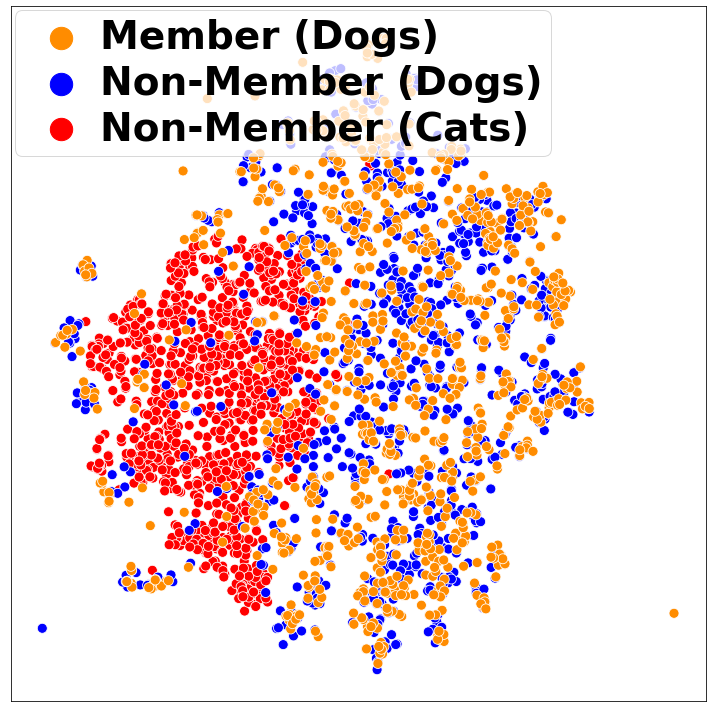

In [36]:
create_tsne2(model, member_target, non_member_target, afhq_cats, 'tsne_standard.pdf', add_legend=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


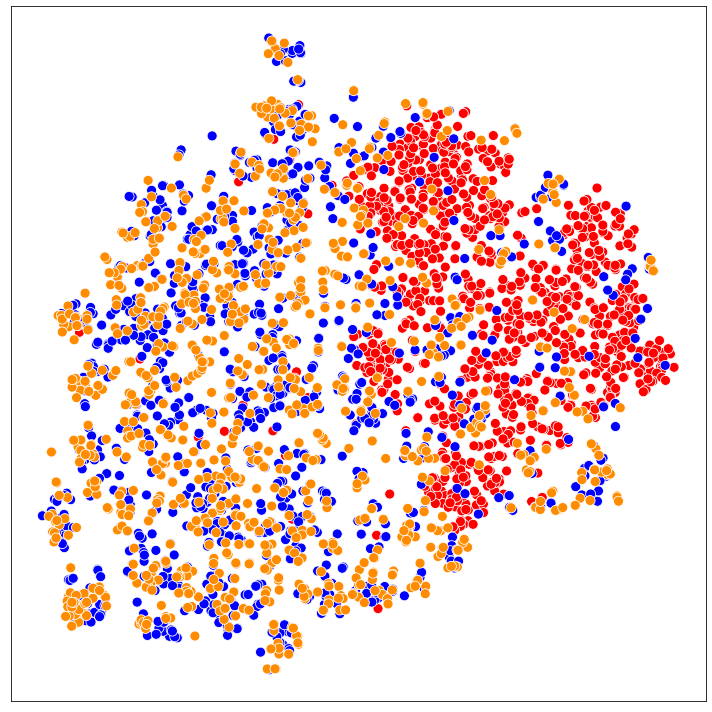

In [37]:
create_tsne2(model_regularized, member_target, non_member_target, afhq_cats, 'tsne_regularized.pdf')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


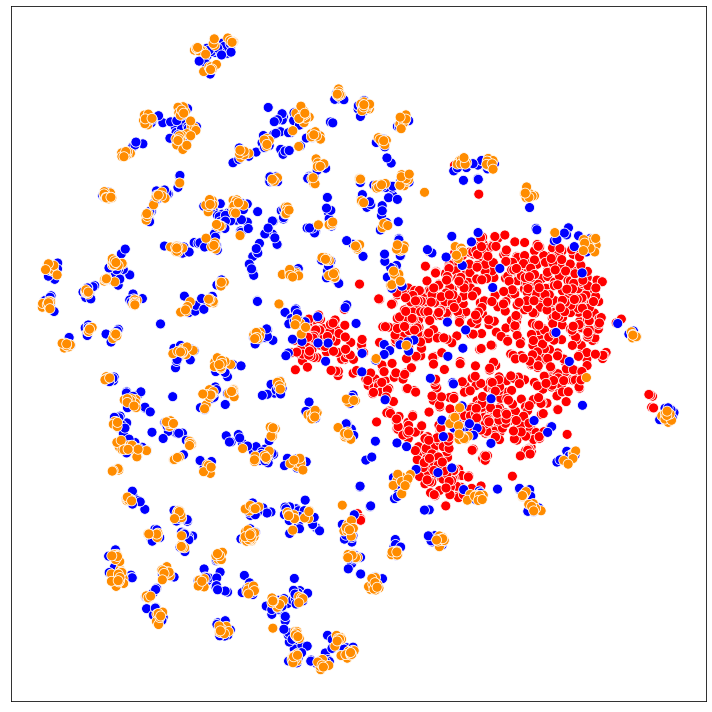

In [38]:
create_tsne2(model_ls, member_target, non_member_target, afhq_cats, 'tsne_ls.pdf')